## Setup and Imports

First, let's set up our Spark environment and import the necessary libraries.

In [0]:
!pip install matplotlib

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes 
from pyspark.sql.functions import col, when, count, lit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

from pyspark.sql import DataFrame
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import roc_curve, auc



You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-2f8c94d1-a34b-4ec7-9b1b-b4fc2730208f/bin/python -m pip install --upgrade pip' command.


## Custom function

#### Plot score distributions

In [0]:
def plot_score_distributions(
    predictions_df: DataFrame,
    label_col: str = "label",
    probability_col: str = "probability", # Assumes this is a vector like [prob_class_0, prob_class_1]
    positive_class_index: int = 1,      # Index of the positive class's probability in the vector
    positive_label_value = 1.0,         # The actual value in label_col for the positive class
    negative_label_value = 0.0          # The actual value in label_col for the negative class
):
    """
    Plots the distribution of predicted scores (probabilities of the positive class)
    for the actual positive and negative classes.

    Args:
        predictions_df (DataFrame): DataFrame containing true labels and predicted probabilities.
                                    Must contain label_col and probability_col.
        label_col (str): Name of the true label column.
        probability_col (str): Name of the column containing probability vectors
                               (e.g., [prob_class_0, prob_class_1] from NaiveBayes).
        positive_class_index (int): Index in the probability_col vector that corresponds
                                    to the probability of the positive class.
        positive_label_value: The value in label_col representing the positive class.
        negative_label_value: The value in label_col representing the negative class.
    """
    print(f"Plotting score distributions. Positive class label: {positive_label_value}, Negative class label: {negative_label_value}")
    print(f"Extracting score for positive class from index {positive_class_index} of '{probability_col}'.")

    try:
        # UDF to extract the probability of the positive class
        extract_positive_prob_udf = udf(lambda prob_vector: float(prob_vector[positive_class_index]) if prob_vector else None, DoubleType())

        temp_score_col = "_positive_score_temp"
        df_with_scores = predictions_df.withColumn(temp_score_col, extract_positive_prob_udf(col(probability_col)))

        # Collect scores for the positive class
        positive_scores = df_with_scores.filter(col(label_col) == positive_label_value) \
                                        .select(temp_score_col).rdd.flatMap(lambda row: row).collect()
        
        # Collect scores for the negative class
        negative_scores = df_with_scores.filter(col(label_col) == negative_label_value) \
                                        .select(temp_score_col).rdd.flatMap(lambda row: row).collect()
        
        # Remove None values that might result if original probability vector was null
        positive_scores = [s for s in positive_scores if s is not None]
        negative_scores = [s for s in negative_scores if s is not None]

        if not positive_scores and not negative_scores:
            print("No scores found to plot for either class.")
            return
        if not positive_scores:
            print(f"No scores found for the positive class (label={positive_label_value}). Plotting only negative class scores.")
        if not negative_scores:
            print(f"No scores found for the negative class (label={negative_label_value}). Plotting only positive class scores.")

        # Plotting using matplotlib
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10, 6))
        
        if positive_scores:
            plt.hist(positive_scores, bins=50, alpha=0.7, label=f'Actual Positive Class (Label={positive_label_value}) Scores', color='green')
        if negative_scores:
            plt.hist(negative_scores, bins=50, alpha=0.7, label=f'Actual Negative Class (Label={negative_label_value}) Scores', color='red')
        
        plt.title('Distribution of Predicted Scores for Positive Class by Actual Class')
        plt.xlabel(f'Predicted Probability of Positive Class (Label={positive_label_value})')
        plt.ylabel('Frequency')
        plt.legend(loc='upper center')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show() # Display the plot
        print("Score distribution plot generated. Check your plotting output.")

    except ImportError:
        print("Matplotlib is not installed. Please install it to plot ('pip install matplotlib').")
    except Exception as e:
        print(f"An error occurred while generating the score distribution plot: {e}")
        print("Ensure your DataFrame and column names are correct, and the probability column is a vector type.")

# --- Example Usage (Conceptual - adapt to your actual DataFrame and column names) ---
# Assuming 'predictions_df' is available from your model:
# predictions_df = pipeline_nb_fitted.transform(test_data)

# Define which label value is "fake" (positive) and "true" (negative)
# For example, if 'fake' is label 1 and 'true' is label 0,
# and your NaiveBayes probability vector is [prob_of_label_0, prob_of_label_1]

# plot_score_distributions(
#     predictions_df,
#     label_col="label",
#     probability_col="probability",  # Column containing [prob_class_0, prob_class_1]
#     positive_class_index=1,       # Index for P(label=1) in the probability vector
#     positive_label_value=1.0,       # Value representing the "fake" class in 'label' column
#     negative_label_value=0.0        # Value representing the "true" class in 'label' column
# )


#### Evaluate binary classification model

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql import DataFrame # For type hinting

def evaluate_binary_classification_model(
    predictions_df: DataFrame,
    label_col: str = "label",
    prediction_col: str = "prediction",
    raw_prediction_col: str = "rawPrediction"
):
    """
    Evaluates a binary classification model and prints common metrics.

    Args:
        predictions_df (DataFrame): DataFrame containing true labels and model predictions.
                                    Expected to have columns specified by label_col,
                                    prediction_col, and raw_prediction_col.
        label_col (str): Name of the true label column.
        prediction_col (str): Name of the column with the model's final hard predictions.
        raw_prediction_col (str): Name of the column with raw prediction scores,
                                  typically used for AUC ROC and AUC PR.
    Returns:
        dict: A dictionary containing the calculated metrics.
    """
    print("\nEvaluating model performance for Binary Classification...")

    metrics = {}

    # --- Metrics using MulticlassClassificationEvaluator (still valid for binary cases) ---
    print("\n--- Threshold-based Metrics (Accuracy, F1, Precision, Recall) ---")
    # Accuracy
    accuracy_evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="accuracy"
    )
    accuracy = accuracy_evaluator.evaluate(predictions_df)
    metrics["accuracy"] = accuracy
    print(f"Accuracy = {accuracy:.4f}")

    # F1-Score
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="f1"
    )
    f1_score = f1_evaluator.evaluate(predictions_df)
    metrics["f1_score"] = f1_score
    print(f"F1 Score = {f1_score:.4f}")

    # Weighted Precision
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="weightedPrecision"
    )
    weighted_precision = precision_evaluator.evaluate(predictions_df)
    metrics["weighted_precision"] = weighted_precision
    print(f"Weighted Precision = {weighted_precision:.4f}")

    # Weighted Recall
    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="weightedRecall"
    )
    weighted_recall = recall_evaluator.evaluate(predictions_df)
    metrics["weighted_recall"] = weighted_recall
    print(f"Weighted Recall = {weighted_recall:.4f}")

    # --- Metrics using BinaryClassificationEvaluator (Specific to Binary) ---
    print("\n--- Ranking-based Metrics (AUC ROC, AUC PR) ---")
    # Area Under ROC Curve (AUC ROC)
    try:
        roc_auc_evaluator = BinaryClassificationEvaluator(
            labelCol=label_col,
            rawPredictionCol=raw_prediction_col, # Uses raw scores or probabilities
            metricName="areaUnderROC"
        )
        auc_roc = roc_auc_evaluator.evaluate(predictions_df)
        metrics["auc_roc"] = auc_roc
        print(f"Area Under ROC (AUC ROC) = {auc_roc:.4f}")
    except Exception as e:
        print(f"Could not calculate AUC ROC. Error: {e}")
        print(f"Ensure '{raw_prediction_col}' column exists and is in the correct format (double or vector for label 1 probability).")
        metrics["auc_roc"] = None

    # Area Under Precision-Recall Curve (AUC PR)
    try:
        pr_auc_evaluator = BinaryClassificationEvaluator(
            labelCol=label_col,
            rawPredictionCol=raw_prediction_col, # Uses raw scores or probabilities
            metricName="areaUnderPR"
        )
        auc_pr = pr_auc_evaluator.evaluate(predictions_df)
        metrics["auc_pr"] = auc_pr
        print(f"Area Under Precision-Recall Curve (AUC PR) = {auc_pr:.4f}")
    except Exception as e:
        print(f"Could not calculate AUC PR. Error: {e}")
        print(f"Ensure '{raw_prediction_col}' column exists and is in the correct format.")
        metrics["auc_pr"] = None
        
    print("\nEvaluation complete.")
    return metrics

#### Compare mode metrics

In [0]:
import pandas as pd

def compare_model_metrics(model_metrics_list, model_names_list):
    """
    Creates and displays a comparison table for metrics from multiple models.

    Args:
        model_metrics_list (list): A list of dictionaries, where each dictionary
                                   contains the metrics for a model.
                                   Example: [{'accuracy': 0.9, 'f1_score': 0.89, ...}, {...}]
        model_names_list (list): A list of strings, representing the names of the models,
                                 corresponding to the order in model_metrics_list.

    Returns:
        pandas.DataFrame: A DataFrame containing the comparison of metrics.
                          Returns None if inputs are invalid.
    """
    if not isinstance(model_metrics_list, list) or not isinstance(model_names_list, list):
        print("Error: model_metrics_list and model_names_list must be lists.")
        return None
    if len(model_metrics_list) != len(model_names_list):
        print("Error: The list of metrics and the list of model names must have the same length.")
        return None
    if not model_metrics_list:
        print("Error: The model_metrics_list is empty.")
        return None

    # Prepare data for Pandas DataFrame
    # We'll create a list of dictionaries, where each dictionary is a row (a model's metrics)
    data_for_df = []
    for i, metrics_dict in enumerate(model_metrics_list):
        if not isinstance(metrics_dict, dict):
            print(f"Warning: Item at index {i} in model_metrics_list is not a dictionary. Skipping.")
            continue
        
        # Create a new dictionary that includes the model name and then the metrics
        row_data = {'Model Name': model_names_list[i]}
        row_data.update(metrics_dict) # Add all metrics from the input dictionary
        data_for_df.append(row_data)

    if not data_for_df:
        print("No valid data to create comparison table.")
        return None

    # Create Pandas DataFrame
    comparison_df = pd.DataFrame(data_for_df)

    # Define a preferred order for metric columns if possible, others will be appended
    # Based on your example output:
    preferred_metric_order = [
        'accuracy', 'f1_score', 'weighted_precision',
        'weighted_recall', 'auc_roc', 'auc_pr'
    ]
    
    # Start with 'Model Name'
    ordered_columns = ['Model Name']
    
    # Add preferred metrics if they exist in the DataFrame
    for metric in preferred_metric_order:
        if metric in comparison_df.columns:
            ordered_columns.append(metric)
            
    # Add any other metric columns that might exist but weren't in the preferred list
    for col in comparison_df.columns:
        if col not in ordered_columns:
            ordered_columns.append(col)
            
    comparison_df = comparison_df[ordered_columns]

    print("\n--- Model Performance Comparison ---")
    # For better display in environments like Jupyter/Databricks,
    # just returning the DataFrame and letting the environment display it is often best.
    # print(comparison_df.to_string()) # .to_string() ensures it prints well in most consoles
    
    return comparison_df


## Data processing functions

#### Tokenize text

In [0]:
def tokenize_text(df, text_column="text", output_column="tokens"):
    """
    Tokenize text into words.
    
    Args:
        df: DataFrame with text column
        text_column (str): Name of the text column
        output_column (str): Name of the output column for tokens
        
    Returns:
        DataFrame: DataFrame with tokenized text
    """
    print("Tokenizing text...")
    
    # Create a tokenizer
    tokenizer = Tokenizer(inputCol=text_column, outputCol=output_column)
    
    # Apply tokenization
    tokenized_df = tokenizer.transform(df)
    
    return tokenized_df


#### Remove stopwords

In [0]:
def remove_stopwords(df, tokens_column="tokens", output_column="filtered_tokens"):
    """
    Remove stopwords from tokenized text.
    
    Args:
        df: DataFrame with tokens column
        tokens_column (str): Name of the tokens column
        output_column (str): Name of the output column for filtered tokens
        
    Returns:
        DataFrame: DataFrame with stopwords removed
    """
    print("Removing stopwords...")
    
    # Create a stopwords remover
    remover = StopWordsRemover(inputCol=tokens_column, outputCol=output_column)
    
    # Apply stopwords removal
    filtered_df = remover.transform(df)
    
    return filtered_df

## Get data from Parquet

In [0]:
df = spark.read.parquet("/dbfs/FileStore/fake_news_detection/data/processed/combined_news.parquet")

In [0]:
df.columns

Out[110]: ['title', 'text', 'location', 'news_source', 'label']

In [0]:
# impute unknown location and source if null
from pyspark.sql.functions import col, when

df = df.withColumn("location", \
          when(col("location").isNull(), "Unknown_Location") \
               .otherwise(col("location"))) \
          .withColumn("news_source", \
               when(col("news_source").isNull(), "Unknown_Source") \
          .otherwise(col("news_source")))

In [0]:
display(df.limit(10))

title text location news_source label abc news emails show hillary s top aide arranged special seating at state dinner for top clinton donors video this woman should be in a jail cell not sitting around laughing and opening pickle jars on the jimmy fallon show judicial watch s release this week of 725 pages of state department emails involving hillary clinton aide huma abedin demonstrates the obama administration considers a large percentage of the emails sent through clinton s private server too sensitive for congress or the american public to read of the 725 pages more than 250 pages were 100 percent redacted many with page denied stamped in bold judicial watch said the new cache includes previously unreleased email exchanges in which former abedin provided influential clinton foundation donors special expedited access to the secretary of state judicial watch added that in many instances the preferential treatment provided to donors was at the specific request of clinton foundation executive douglas band the abedin emails reveal that the longtime clinton aide apparently served as a conduit between clinton foundation donors and hillary clinton while clinton served as secretary of state in more than a dozen email exchanges abedin provided expedited direct access to clinton for donors who had contributed from 25 000 to 10 million to the clinton foundation judicial watch said in a statement announcing the release wndwatch #crookedhillary scandal #9 999 and counting Unknown_Location Unknown_Source 0 black men for bernie founder campaigns in swing states for trump bill and hillary did major damage to our communities last time in white house video apparently using thug michael ferguson s mom as a prop at black functions was not enough to be granted the black vote black men for bernie founder bruce carter s mission to restore black communities didn t end when vermont senator bernie sanders lost to hillary clinton in the democratic primary he opposed hillary clinton and the democratic establishment then because he knew that they didn t represent the minority communities he engaged in politics to fight for after the leak of internal dnc emails carter is convinced that the democratic party rigged the primary against his candidate and that hillary clinton s democratic party has no intention of changing the policies that led to the destruction of the communities he s working to improve bruce carter still believes that hillary clinton is the poster child for the kind of cronyism corruption and evil that the bernie revolution was built to overthrow he doesn t believe hillary clinton when she labels donald trump and his supporters as racists because he knows she falsely labeled her opponents in the primary as sexist bernie bros carter s preparing to take the experience knowledge and contacts his group built during the primary to campaign against hillary clinton and for donald trump and other republicans in battleground states across the country bruce carter and black men for bernie are at war with the democratic establishment whom he says pander for votes but haven t delivered meaningful results to minority communities for decades carter became politically active to support bernie sanders who taught him how the establishment s only real constituency was the donor class when he paired that knowledge with what he knew about the decline in the black and minority neighborhoods he loves he realized democratic politicians and the media had been lying bernie inspired us to disrupt the status quo because it only works for the elites and not regular people who are struggling carter told breitbart news if black communities vote for hillary clinton and democrats in november nothing will change because democrats will continue to believe they don t have to do anything to earn our votes carter became one of the most prominent and recognizable supporters of the sanders campaign by traveling the country in a tour bus and fleet of vehicles wrapped with the 

In [0]:
df_label = df.groupBy("label").count()
print("Number of records by label:")
df_label.show()
df_label.unpersist()

Number of records by label:
+-----+-----+
|label|count|
+-----+-----+
|    0|23489|
|    1|21417|
+-----+-----+

Out[113]: DataFrame[label: int, count: bigint]

In [0]:
df.show()

+--------------------+--------------------+----------------+--------------+-----+
|               title|                text|        location|   news_source|label|
+--------------------+--------------------+----------------+--------------+-----+
|abc news emails s...|this woman should...|Unknown_Location|Unknown_Source|    0|
|black men for ber...|apparently using ...|Unknown_Location|Unknown_Source|    0|
|mn why did police...|republican presid...|Unknown_Location|Unknown_Source|    0|
|actor tim allen h...|megyn what about ...|Unknown_Location|Unknown_Source|    0|
|hill arious video...|this video brilli...|Unknown_Location|Unknown_Source|    0|
|eric trump says p...|millennial propag...|Unknown_Location|Unknown_Source|    0|
|offending the glo...|freedom of speech...|Unknown_Location|Unknown_Source|    0|
|cnn cancels popul...|another stunning ...|Unknown_Location|Unknown_Source|    0|
|#crookedhillary u...|hillary clinton i...|Unknown_Location|Unknown_Source|    0|
|when #blacklive

## Split data for training

In [0]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

## Impute nulls

In [0]:
# Handle Nulls by imputing with empty strings

print("Original train_data schema:")
train_data.printSchema()
print("Original train_data null text count:")
train_data.filter(col("text").isNull()).show()


print("Imputing nulls in 'text' and 'title' columns for train_data...")
train_data = train_data.na.fill({
    "text": "",  
    "title": ""  
})

print("Imputing nulls in 'text' and 'title' columns for test_data...")
test_data = test_data.na.fill({
    "text": "",
    "title": ""
})


Original train_data schema:
root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- location: string (nullable = true)
 |-- news_source: string (nullable = true)
 |-- label: integer (nullable = true)

Original train_data null text count:
+--------------------+----+----------------+--------------+-----+
|               title|text|        location|   news_source|label|
+--------------------+----+----------------+--------------+-----+
|                    |null|Unknown_Location|Unknown_Source|    0|
|                    |null|Unknown_Location|Unknown_Source|    0|
|ex gop congressma...|null|Unknown_Location|Unknown_Source|    0|
|watch democratic ...|null|Unknown_Location|Unknown_Source|    0|
+--------------------+----+----------------+--------------+-----+

Imputing nulls in 'text' and 'title' columns for train_data...
Imputing nulls in 'text' and 'title' columns for test_data...


In [0]:
print("Null counts in train_data:")
train_data.select(
    count(when(col("text").isNull(), "text")).alias("null_text_train"),
    count(when(col("title").isNull(), "title")).alias("null_title_train")
).show()

print("Null counts in test_data:")
test_data.select(
    count(when(col("text").isNull(), "text")).alias("null_text_test"),
    count(when(col("title").isNull(), "title")).alias("null_title_test")
).show()

Null counts in train_data:
+---------------+----------------+
|null_text_train|null_title_train|
+---------------+----------------+
|              0|               0|
+---------------+----------------+

Null counts in test_data:
+--------------+---------------+
|null_text_test|null_title_test|
+--------------+---------------+
|             0|              0|
+--------------+---------------+



## TF-IDF Model 

### Model with all features (location, news_source, text, title)

##### Stages for Categorical Features ('location', 'news_source')

In [0]:
indexer_location = StringIndexer(
    inputCol="location",
    outputCol="location_index",
    handleInvalid="keep",  # to handle unseen labels in test data
    stringOrderType="frequencyDesc"
)

# StringIndexer for 'news_source'
indexer_news_source = StringIndexer(
    inputCol="news_source",
    outputCol="news_source_index",
    handleInvalid="keep",
    stringOrderType="frequencyDesc"
)

# OneHotEncoder for the indexed categorical columns
# Takes the output of both StringIndexers
encoder_categorical = OneHotEncoder(
    inputCols=["location_index", "news_source_index"],
    outputCols=["location_vec", "news_source_vec"],
    dropLast=False  
)

##### Stages for 'text' Feature

In [0]:
# Tokenizer for 'text'
text_tokenizer = Tokenizer(inputCol="text", outputCol="text_words")

# StopWordsRemover for 'text_words'
text_stopwords_remover = StopWordsRemover(inputCol="text_words", outputCol="filtered_text_words")

# HashingTF for 'filtered_text_words'
text_hashing_tf = HashingTF(
    inputCol="filtered_text_words",
    outputCol="text_tf_features",
    numFeatures=20000  # Number of features for the main text
)

# IDF for 'text_tf_features'
text_idf = IDF(inputCol="text_tf_features", outputCol="text_tfidf_features")

##### Stages for 'title' Feature

In [0]:
##### Stages for 'title' Feature

# Tokenizer for 'title'
title_tokenizer = Tokenizer(inputCol="title", outputCol="title_words")

# StopWordsRemover for 'title_words'
title_stopwords_remover = StopWordsRemover(inputCol="title_words", outputCol="filtered_title_words")

# HashingTF for 'filtered_title_words'
# Titles are usually shorter, so you might use fewer features, or the same as text.
title_hashing_tf = HashingTF(
    inputCol="filtered_title_words",
    outputCol="title_tf_features",
    numFeatures=10000  
)

# IDF for 'title_tf_features'
title_idf = IDF(inputCol="title_tf_features", outputCol="title_tfidf_features")

#####  Assemble all generated features into a single feature vector 


In [0]:
feature_assembler = VectorAssembler(
    inputCols=[
        "text_tfidf_features",
        "title_tfidf_features",
        "location_vec",
        "news_source_vec"
    ],
    outputCol="features"
)

**Model with location, news source, title, text**

In [0]:
nb_estimator_all_features = NaiveBayes(
    labelCol="label",
    featuresCol="features",
    modelType="multinomial" 
)

In [0]:
model_nb_all_features = Pipeline(stages=[
    # Categorical feature processing
    indexer_location,
    indexer_news_source,
    encoder_categorical,
    # Text (main body) processing
    text_tokenizer,
    text_stopwords_remover,
    text_hashing_tf,
    text_idf,
    # Title processing
    title_tokenizer,
    title_stopwords_remover,
    title_hashing_tf,
    title_idf,
    # Assemble all features
    feature_assembler,
    # Add the Naive Bayes model estimator
    nb_estimator_all_features 
])

In [0]:
# Fitting the model
model_nb_fitted_all_features = model_nb_all_features.fit(train_data)

In [0]:
# Making predictions on test data 
predictions_model_nb_fitted_all_features = model_nb_fitted_all_features.transform(test_data)

In [0]:
print("\nSample of predictions (showing original label, text, and prediction details):")
predictions_model_nb_fitted_all_features.select("text", "label", "rawPrediction", "probability", "prediction").show(10, truncate=50)


Sample of predictions (showing original label, text, and prediction details):
+--------------------------------------------------+-----+-----------------------------------------+-----------------------------+----------+
|                                              text|label|                            rawPrediction|                  probability|prediction|
+--------------------------------------------------+-----+-----------------------------------------+-----------------------------+----------+
|george soros funded obama approved domestic ter...|    0| [-3363.3579644299307,-3664.536122912614]|[1.0,1.5848483104081608E-131]|       0.0|
|we re thinking it s having the opposite effect ...|    0| [-1753.771759683352,-1875.7431396655722]|  [1.0,1.067831489224507E-53]|       0.0|
|sanctioned domestic terrorists taking direction...|    0|  [-7212.811887630382,-7649.156250140638]| [1.0,3.148119084979175E-190]|       0.0|
|disney has officially begun to push a gay agend...|    0|  [-9474.12

In [0]:
print("\nEvaluating model performance for 'Fake vs. True' classification...")

# --- Metrics using MulticlassClassificationEvaluator ---
# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions_model_nb_fitted_all_features)
print(f"Accuracy = {accuracy:.4f}")

# F1-Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions_model_nb_fitted_all_features)
print(f"F1 Score = {f1_score:.4f}")

# Weighted Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
weighted_precision = precision_evaluator.evaluate(predictions_model_nb_fitted_all_features)
print(f"Weighted Precision = {weighted_precision:.4f}")

# Weighted Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
weighted_recall = recall_evaluator.evaluate(predictions_model_nb_fitted_all_features)
print(f"Weighted Recall = {weighted_recall:.4f}")

# --- Metrics using BinaryClassificationEvaluator (Specific to Binary) ---
# This evaluator expects a raw prediction or probability column that indicates the score for the "positive" class.
# By default, it uses 'rawPrediction'

# Area Under ROC Curve (AUC ROC)
# AUC ROC measures the ability of the classifier to distinguish between classes.
# A value closer to 1 is better. 0.5 is random guessing.
roc_auc_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_roc = roc_auc_evaluator.evaluate(predictions_model_nb_fitted_all_features)
print(f"Area Under ROC (AUC ROC) = {auc_roc:.4f}")

# Area Under Precision-Recall Curve (AUC PR)
# AUC PR is often more informative for imbalanced datasets.
pr_auc_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
auc_pr = pr_auc_evaluator.evaluate(predictions_model_nb_fitted_all_features)
print(f"Area Under Precision-Recall Curve (AUC PR) = {auc_pr:.4f}")


Evaluating model performance for 'Fake vs. True' classification...
Accuracy = 0.9441
F1 Score = 0.9441
Weighted Precision = 0.9445
Weighted Recall = 0.9441
Area Under ROC (AUC ROC) = 0.5385
Area Under Precision-Recall Curve (AUC PR) = 0.5146


Face value the Naive Bayes model has a high F1 score but is not able to capture complex relationships needed to truly separate the classes across a range of confidence levels as indicated by the very low AUC.

In [0]:
print("Label distribution in predictions_df (from test data):")
predictions_model_nb_fitted_all_features.groupBy("label").count().show()
# Also check on your original train_data
# train_data.groupBy("label").count().show()

Label distribution in predictions_df (from test data):
+-----+-----+
|label|count|
+-----+-----+
|    0| 4558|
|    1| 4251|
+-----+-----+



In [0]:
print("Confusion Matrix:")
predictions_model_nb_fitted_all_features.groupBy("label", "prediction").count().show()

Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0| 4375|
|    0|       1.0|  183|
|    1|       0.0|  309|
|    1|       1.0| 3942|
+-----+----------+-----+



In [0]:
# Confirm function is returning the same results

stored_metrics_model_nb_fitted_all_features = evaluate_binary_classification_model(predictions_model_nb_fitted_all_features)
print("\nReturned metrics dictionary:")
print(stored_metrics_nb_all_features)


Evaluating model performance for Binary Classification...

--- Threshold-based Metrics (Accuracy, F1, Precision, Recall) ---
Accuracy = 0.9441
F1 Score = 0.9441
Weighted Precision = 0.9445
Weighted Recall = 0.9441

--- Ranking-based Metrics (AUC ROC, AUC PR) ---
Area Under ROC (AUC ROC) = 0.5385
Area Under Precision-Recall Curve (AUC PR) = 0.5146

Evaluation complete.

Returned metrics dictionary:
{'accuracy': 0.9441480304234305, 'f1_score': 0.9441086668695291, 'weighted_precision': 0.9444570675679288, 'weighted_recall': 0.9441480304234307, 'auc_roc': 0.5384963752689014, 'auc_pr': 0.5146140093461739}


In [0]:
#### Save the model 
model_nb_fitted_all_features.write().overwrite().save("dbfs:/dbfs/FileStore/fake_news_detection/models")
print("** Naive Bayes model with all features saved.")

** Naive Bayes model with all features saved.


### Model with 'text' only 

In [0]:
nb_estimator_text_only = NaiveBayes(
    labelCol="label",
    featuresCol="features_text_only",
    modelType="multinomial" 
)

feature_assembler_text_only = VectorAssembler(
    inputCols=[
        "text_tfidf_features",
    ],
    outputCol="features_text_only" # input to nb_model_text_only
)

model_nb_text_only = Pipeline(stages=[
    # Text (main body) processing
    text_tokenizer,
    text_stopwords_remover,
    text_hashing_tf,
    text_idf,
    # Assemble all features
    feature_assembler_text_only,
    # Add the Naive Bayes model estimator
    nb_model_text_only
])
model_nb_fitted_text_only = model_nb_text_only.fit(train_data)


In [0]:
# Making predictions on test data 
predictions_model_nb_fitted_text_only = model_nb_fitted_text_only.transform(test_data)

In [0]:
print("Label distribution in predictions_df (from test data):")
predictions_model_nb_fitted_text_only.groupBy("label").count().show()


Label distribution in predictions_df (from test data):
+-----+-----+
|label|count|
+-----+-----+
|    0| 4558|
|    1| 4251|
+-----+-----+



In [0]:
stored_metrics_model_nb_fitted_text_only  = evaluate_binary_classification_model(predictions_model_nb_fitted_text_only)


Evaluating model performance for Binary Classification...

--- Threshold-based Metrics (Accuracy, F1, Precision, Recall) ---
Accuracy = 0.9300
F1 Score = 0.9299
Weighted Precision = 0.9304
Weighted Recall = 0.9300

--- Ranking-based Metrics (AUC ROC, AUC PR) ---
Area Under ROC (AUC ROC) = 0.5236
Area Under Precision-Recall Curve (AUC PR) = 0.5006

Evaluation complete.


In [0]:
#### Save the model 
model_nb_text_only.write().overwrite().save("dbfs:/dbfs/FileStore/fake_news_detection/models")
print("** Naive Bayes model with only text feature saved.")

** Naive Bayes model with only text feature saved.


## RF Model

In [0]:
rf_estimator_text_only = RandomForestClassifier(labelCol="label", featuresCol="features_text_only", numTrees=10, maxDepth=4, seed=42)

feature_assembler_text_only = VectorAssembler(
    inputCols=[
        "text_tfidf_features",
    ],
    outputCol="features_text_only" # input to rf_model_text_only
)

model_rf_text_only = Pipeline(stages=[
    # Text (main body) processing
    text_tokenizer,
    text_stopwords_remover,
    text_hashing_tf,
    text_idf,
    # Assemble all features
    feature_assembler_text_only,
    # Add the Naive Bayes model estimator
    rf_estimator_text_only
])

print("Fitting RandomForest pipeline...")
model_rf_fitted_text_only = model_rf_text_only.fit(train_data)
print("Fitting complete.")

print("Making predictions with RandomForest model...")
predictions_model_rf_fitted_text_only = model_rf_fitted_text_only.transform(test_data)
print("Predictions complete.")

print("Evaluating RandomForest model...")
stored_metrics_model_rf_fitted_text_only = evaluate_binary_classification_model(predictions_model_rf_fitted_text_only )
print("RandomForest Model Metrics:", stored_metrics_model_rf_fitted_text_only)


Fitting RandomForest pipeline...
Fitting complete.
Making predictions with RandomForest model...
Predictions complete.
Evaluating RandomForest model...

Evaluating model performance for Binary Classification...

--- Threshold-based Metrics (Accuracy, F1, Precision, Recall) ---
Accuracy = 0.8189
F1 Score = 0.8175
Weighted Precision = 0.8249
Weighted Recall = 0.8189

--- Ranking-based Metrics (AUC ROC, AUC PR) ---
Area Under ROC (AUC ROC) = 0.9151
Area Under Precision-Recall Curve (AUC PR) = 0.9036

Evaluation complete.
RandomForest Model Metrics: {'accuracy': 0.8189351799296174, 'f1_score': 0.8175157676670333, 'weighted_precision': 0.8248851766246852, 'weighted_recall': 0.8189351799296174, 'auc_roc': 0.9151394210318731, 'auc_pr': 0.9036273682911267}


In [0]:
#### Save the model 
model_rf_text_only.write().overwrite().save("dbfs:/dbfs/FileStore/fake_news_detection/models")
print("** Random Forest model saved.")

** Random Forest model saved.


## Compare model metrics

In [0]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.types import DoubleType

# Define UDF to extract probability of class 1 (index 1 in vector)
def get_prob1(v):
    return float(v[1])

extract_prob_udf = udf(get_prob1, DoubleType())

# Apply UDF to both models' predictions
rf_points = predictions_model_rf_fitted_text_only.select("label", extract_prob_udf("probability").alias("prob1")).toPandas()
nb_points_text_only = predictions_model_nb_fitted_text_only.select("label", extract_prob_udf("probability").alias("prob1")).toPandas()
nb_points_all_features = predictions_model_nb_fitted_all_features.select("label", extract_prob_udf("probability").alias("prob1")).toPandas()

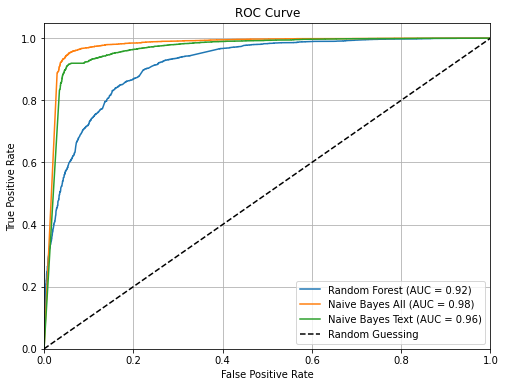

In [0]:
# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(rf_points["label"], rf_points["prob1"])
auc_rf_score = auc(fpr_rf, tpr_rf)

# Naive Bayes with all features 
fpr_nb_all_features, tpr_nb_all_features, _ = roc_curve(nb_points_all_features["label"], nb_points_all_features["prob1"])
auc_nb_score_all_features = auc(fpr_nb_all_features, tpr_nb_all_features)

# Naive Bayes with only text
fpr_nb_text_only, tpr_nb_text_only, _ = roc_curve(nb_points_text_only["label"], nb_points_text_only["prob1"])
auc_nb_score_text_only = auc(fpr_nb_text_only, tpr_nb_text_only)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf_score:.2f})")
plt.plot(fpr_nb_all_features, tpr_nb_all_features, label=f"Naive Bayes All (AUC = {auc_nb_score_all_features:.2f})")
plt.plot(fpr_nb_text_only, tpr_nb_text_only, label=f"Naive Bayes Text (AUC = {auc_nb_score_text_only:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.xlim([0.0, 1.0]) # Ensure x-axis is from 0 to 1
plt.ylim([0.0, 1.05]) # Ensure y-axis is from 0 to 1 (or slightly above for legend)
plt.show()

plt.show()

In [0]:
# List of your metrics dictionaries
all_model_metrics = [
stored_metrics_model_nb_fitted_all_features,
stored_metrics_model_nb_fitted_text_only,
stored_metrics_model_rf_fitted_text_only
]

model_names = [
"Naive Bayes (All Features)",
"Naive Bayes (Text Only)",
"Random Forest (Text Only)"
]

comparison_table = compare_model_metrics(all_model_metrics, model_names)

display(comparison_table) 


--- Model Performance Comparison ---


Model Name,accuracy,f1_score,weighted_precision,weighted_recall,auc_roc,auc_pr
Naive Bayes (All Features),0.9441480304234305,0.9441086668695291,0.9444570675679288,0.9441480304234307,0.5384954720924142,0.5146167362933181
Naive Bayes (Text Only),0.9299579975025543,0.929894297349866,0.9303941342346536,0.9299579975025543,0.5236077173179395,0.500583593727722
Random Forest (Text Only),0.8189351799296174,0.8175157676670333,0.8248851766246852,0.8189351799296174,0.9151394210318731,0.9036273682911267
